# 1 - Importacão das bibliotecas

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

# Entendimento dos dados

## Load the dataset

In [4]:
path = '~/repos/Projetos-Data-Science/Projeto House Rocket/dataset/kc_house_data.csv'

def data_collect(path):
    dataframe = pd.read_csv(path, parse_dates=['date'])

    return dataframe

data = data_collect(path)
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.00,3,1.00,1180,5650,1.00,0,0,...,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,6414100192,2014-12-09,538000.00,3,2.25,2570,7242,2.00,0,0,...,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
2,5631500400,2015-02-25,180000.00,2,1.00,770,10000,1.00,0,0,...,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
3,2487200875,2014-12-09,604000.00,4,3.00,1960,5000,1.00,0,0,...,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
4,1954400510,2015-02-18,510000.00,3,2.00,1680,8080,1.00,0,0,...,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503


In [5]:
# Dimensions of the data

def show_dimensions(data):
    print(f'Quantidade de linhas do dataset {data.shape[0]}')
    print(f'Quantidade de colunas do dataset {data.shape[1]}\n')
    
    return None

def show_dtypes(data):
    # Data Types
    data.info()
    
    return None

# Limpeza dos dados

In [6]:
show_dimensions(data)

Quantidade de linhas do dataset 21613
Quantidade de colunas do dataset 21



In [ ]:
# Tratando dados duplicados
data['id'].nunique()

In [ ]:
id_counts = data['id'].value_counts()
dupe_ids = id_counts > 1
dupe_mask = id_counts.index[dupe_ids]

dupe_maks = list(dupe_mask)
data.loc[data['id'].isin(dupe_mask), : ].head(int(len(dupe_mask) * 0.2))

In [ ]:
data.drop_duplicates(subset='id', keep='last', inplace=True)

In [ ]:
show_dimensions(data)

In [5]:
# Trantando outliers
data.describe()
#sns.boxplot(x = 'bedrooms', data=data, orient='h')

NameError: name 'data' is not defined

In [6]:
data['bathrooms'].unique()

NameError: name 'data' is not defined

In [13]:
data.head()

NameError: name 'data' is not defined

In [19]:
data.describe(include= 'int64')

,id,bedrooms,sqft_living,sqft_lot,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
count,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00
mean,4580301520.86,3.37,2079.90,15106.97,0.01,0.23,3.41,7.66,1788.39,291.51,1971.01,84.40,98077.94,1986.55,12768.46
std,2876565571.31,0.93,918.44,41420.51,0.09,0.77,0.65,1.18,828.09,442.58,29.37,401.68,53.51,685.39,27304.18
min,1000102.00,0.00,290.00,520.00,0.00,0.00,1.00,1.00,290.00,0.00,1900.00,0.00,98001.00,399.00,651.00
25%,2123049194.00,3.00,1427.00,5040.00,0.00,0.00,3.00,7.00,1190.00,0.00,1951.00,0.00,98033.00,1490.00,5100.00
50%,3904930410.00,3.00,1910.00,7618.00,0.00,0.00,3.00,7.00,1560.00,0.00,1975.00,0.00,98065.00,1840.00,7620.00
75%,7308900445.00,4.00,2550.00,10688.00,0.00,0.00,4.00,8.00,2210.00,560.00,1997.00,0.00,98118.00,2360.00,10083.00
max,9900000190.00,33.00,13540.00,1651359.00,1.00,4.00,5.00,13.00,9410.00,4820.00,2015.00,2015.00,98199.00,6210.00,871200.00


In [21]:
data.describe(include= 'float64')

,price,bathrooms,floors,lat,long
count,21613.00,21613.00,21613.00,21613.00,21613.00
mean,540088.14,2.11,1.49,47.56,-122.21
std,367127.20,0.77,0.54,0.14,0.14
min,75000.00,0.00,1.00,47.16,-122.52
25%,321950.00,1.75,1.00,47.47,-122.33
50%,450000.00,2.25,1.50,47.57,-122.23
75%,645000.00,2.50,2.00,47.68,-122.12
max,7700000.00,8.00,3.50,47.78,-121.31


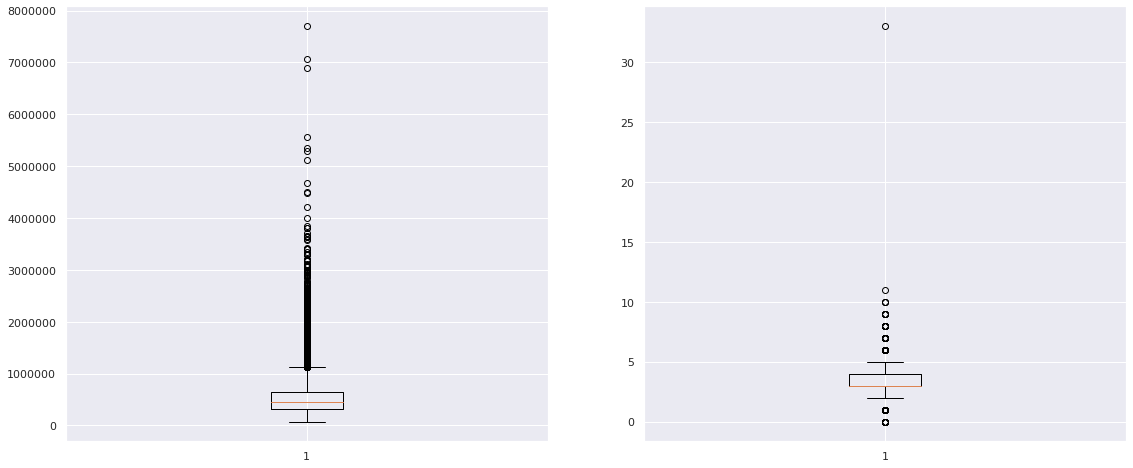

In [16]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(19,8))

bplot1 = axes[0].boxplot(data['price'])

https://matplotlib.org/3.1.0/gallery/statistics/boxplot_color.html

bplot2 = axes[1].boxplot(data['bedrooms'])

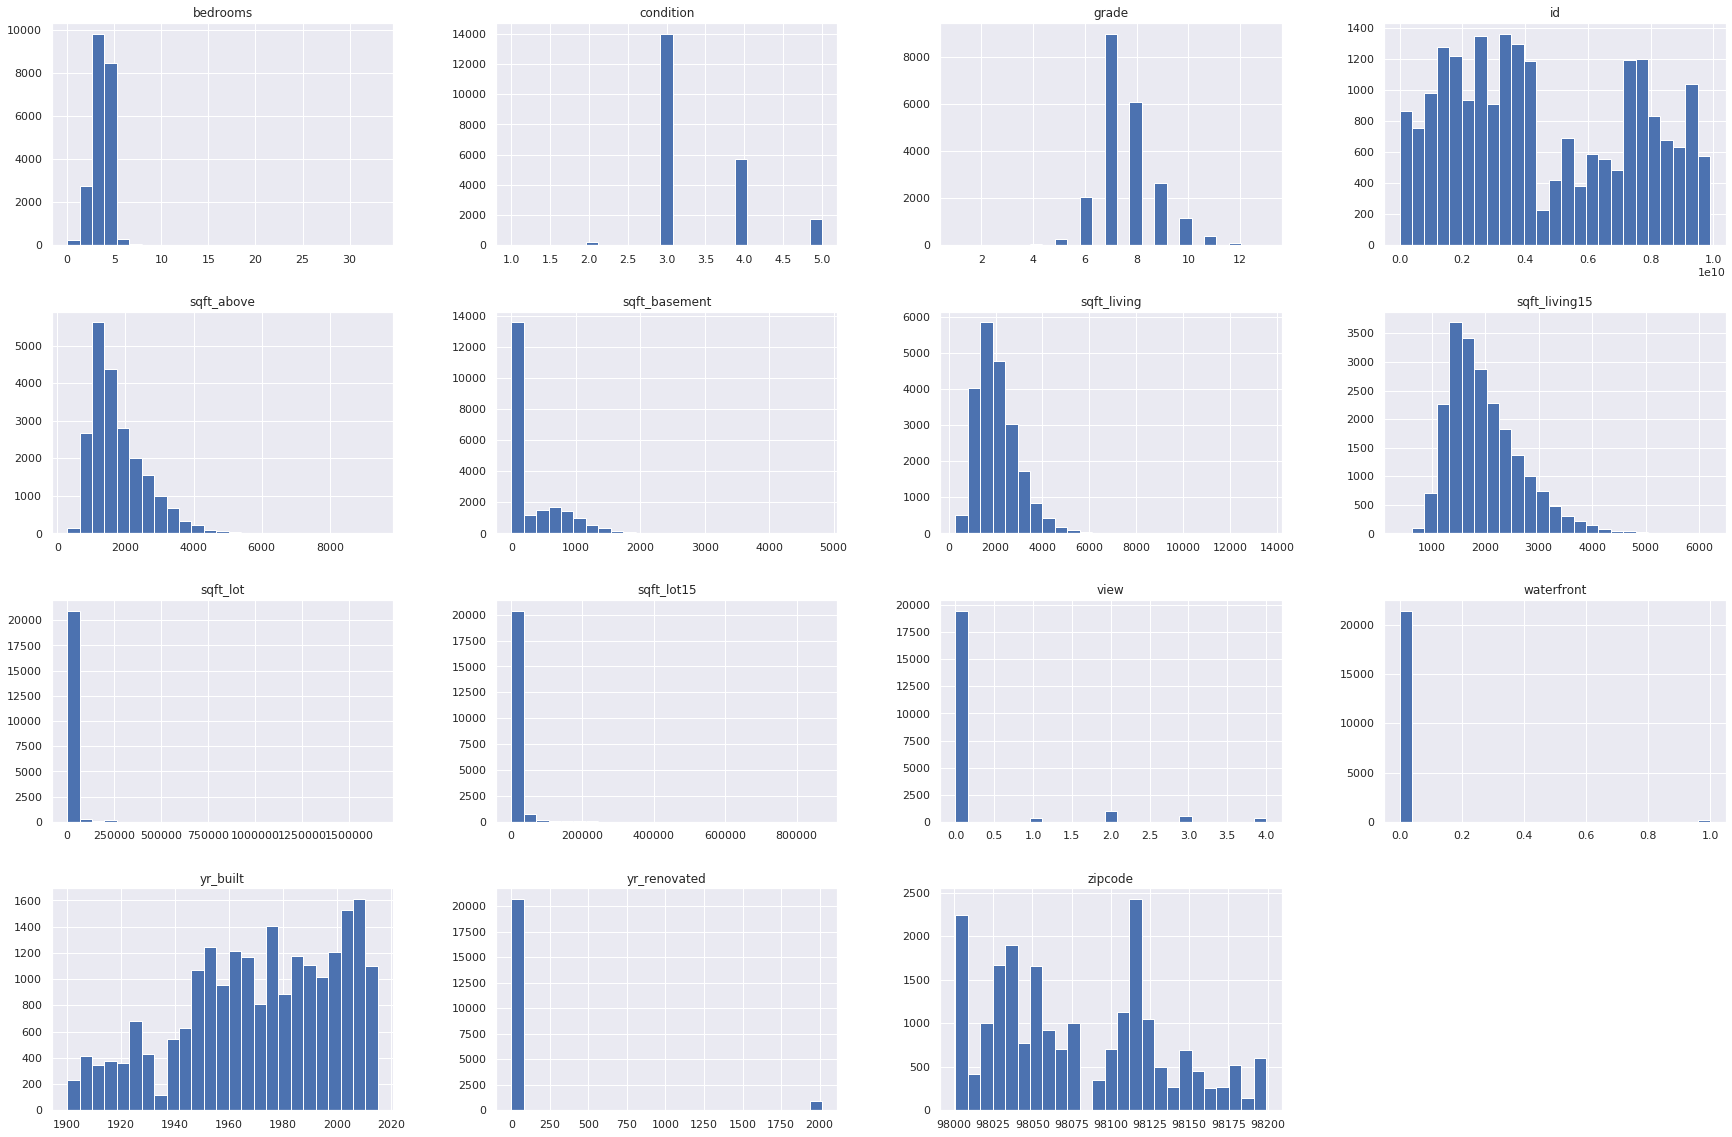

In [8]:
num_df4 = data.select_dtypes(include=['int64'])
sns.set(rc={'figure.figsize': (30,20)})
num_df4.hist(bins=25);


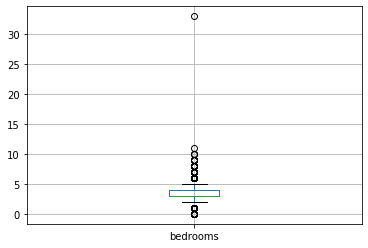

# Transformação dos dados

In [35]:
data['bedrooms'].unique()

array([ 3,  2,  4,  5,  1,  6,  7,  0,  8,  9, 11, 10, 33])

In [24]:
def data_transformation(data):
    
    data['standard'] = data['price'].apply(lambda x: 'high_standard' if x > 540000 else
                                                      'low_standard')
    
    data['dormitory_type'] = data['bedrooms'].apply(lambda x: )
    
    data['condition_type'] = 
    
    data['contruction'] = 
    
    data['basement_status'] = 
    
    
    data['yr_week'] = Colocar essa construção de coluna na documentação
    
    
    
    data['season'] = 
        
    data['waterfront_status'] = 
    
    data['renovated_status'] = 
    
    data['recomendation'] = 
    
    
    
    
    
    
    
    
    
    

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

# Exploração dos dados
 1 - Analise Descritiva

# Featuring Engineer

# Insights para o negocio
 - H1 Imóveis que possuem vista para água, são 30% mais caros, ne média
 - H2: Imóveis com data de construção menor que 1955. são 50% mais baratos, na média
 - H3: Imóveis sem porão possuem sqrt_lot, são 50% maiores do que com porão
 - H4: O crescimento do preço dos imóveis YoY é de 10%
 - H5: Imóveis com 3 banheiros tem um crescimento MoM de 15%
 - H6: Properties with 2 floors are 15% more expensive than those with 1 floor.
 - H7: Most properties (+50%) became available during summer/spring.
 - H8: Properties available during summer/spring are 20% more expensive.
 - H9: Most properties (+50%) are localized in a 15km radius from the lake.
 - H10: Most of properties (+50%) that should be bought are in a 15km radius from the lake.
 - H11: Properties selected to be bought that are localized in a 15km radius from lake correspond to more than 50% of expected profit.
 - H12: Properties have bigger interior living space along construction year timeline.
 - H13: Properties that were not renovated are 40% cheaper.

# Questões do negócio

# Resultados financeiros para o negócio

# Conclusão

# Próximo Passo